In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from sklearn.metrics import roc_curve
import torch
from torch.autograd import Variable

In [89]:
protected_var = 'sex'
if protected_var == 'sex':
  protected_var_categories = ['Male', 'Female']
elif protected_var == 'race':
  protected_var_categories = ['White', 'Black', 'Asian', 'American-Indian', 'Other']
elif protected_var == 'age':
  protected_var_categories = ['0-18', '18-25', '25-30', '30-35', '35-40', '40-45', '45-50',
                              '50-55', '55-60', '60-65', '65+']

In [90]:
# Data paths
path = 'data/adult/'
X_name = path + 'X_valid.pkl' # CHANGE TO VAL
y_name = path + 'y_valid.pkl'
z_name = path + protected_var + '_valid.pkl'

In [91]:
# Load data
def load_data(fname):
  data = pd.read_pickle(fname)
  return data.values, Variable(torch.tensor(data.values).float())

X, X_tensor = load_data(X_name)
y, y_tensor = load_data(y_name)
z, z_tensor = load_data(z_name)

In [117]:
# Model paths
path = 'logs/adult/'
alpha_names = []
# alphas = ['0.1', '0.5', '1', '1.5', '2.5', '5', '7.5', '10']
alphas = ['1', '900']
for alpha in alphas:
  alpha_names.append(path + protected_var + '-odds-alpha-model/' + 'learning_rate_0.001-num_iters_3000-n_h_10-n_h_adv_10-dropout_rate_0.5-alpha_' \
    + alpha + '-model.pth')
  
basic_model_name = path + 'basic-model/' + 'learning_rate_0.001-num_iters_3000-n_h_10--dropout_rate_0.5--model.pth'
odds_model_name = path + protected_var + '-odds-alpha-model/' + 'learning_rate_0.001-num_iters_3000-n_h_10-n_h_adv_10-dropout_rate_0.5-alpha_1-model.pth'
parity_model_name = path + protected_var + '-parity-alpha-model/' + 'learning_rate_0.001-num_iters_3000-n_h_10-n_h_adv_10-dropout_rate_0.5-alpha_1-model.pth'

In [118]:
# Load models
def load_model(fname):
  model = torch.load(fname)
  model.eval()
  return model

basic_model = load_model(basic_model_name)
odds_model = load_model(odds_model_name)
parity_model = load_model(parity_model_name)
alpha_models = {}
for i, alpha in enumerate(alphas):
  alpha_models[alpha] = load_model(alpha_names[i])

/Users/justinchen/miniconda3/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [119]:
def get_roc(model):
  ypred = model(X_tensor).data.numpy().squeeze()
  curves = []
  for i in range(len(protected_var_categories)):
    curves.append(roc_curve(y[z == i], ypred[z == i]))
  return curves
  
basic_roc = get_roc(basic_model)
odds_roc = get_roc(odds_model)
parity_roc = get_roc(parity_model)
alpha_rocs = {}
for alpha in alpha_models:
  alpha_rocs[alpha] = get_roc(alpha_models[alpha])

In [123]:
colors = ['blue', 'green', 'black']
# colors = cm.nipy_spectral(np.linspace(0, 1, len(protected_var_categories)))
linestyle_dict = {'basic': '-', 'odds': '--', 'parity': ':',
                  'alpha: 1': '-', 'alpha: 100': '--', 'alpha: 500': ':', 'alpha: 900': '-.'}
# linestyles = ['-', '--', ':']
# color_dict = {'basic': 'blue', 'odds': 'red', 'parity': 'green'}

def plot_roc(curves, ax, model_type, xrange=None, yrange=None):
  for i, curve in enumerate(curves):
#     if i >= 3: #plot gets too crowded
#       break
    fpr, tpr, thresholds = curve
    if model_type in linestyle_dict:
      ax.plot(fpr, tpr, label = model_type + ': ' + protected_var_categories[i],
              c=colors[i], linestyle=linestyle_dict[model_type])
    else:
      print(model_type)
      ax.plot(fpr, tpr, label = model_type + ': ' + protected_var_categories[i],
             c=colors[i])
  ax.set_xlabel('False positive rate')
  ax.set_ylabel('True positive rate')
  ax.legend()
  if xrange is not None:
    ax.set_xlim(xrange[0], xrange[1])
  if yrange is not None:
    ax.set_ylim(yrange[0], yrange[1])

[1.0000000e+00 9.9978143e-01 9.9976653e-01 ... 2.1245098e-05 2.1188282e-05
 4.6308019e-06]
[1.00000000e+00 9.11784708e-01 9.10191238e-01 8.63726020e-01
 8.62835705e-01 8.26806724e-01 8.22426498e-01 7.95767725e-01
 7.88854420e-01 7.84967065e-01 7.38642275e-01 7.06466496e-01
 6.90519154e-01 6.88983440e-01 6.84822857e-01 6.79965377e-01
 6.66773379e-01 6.64764941e-01 6.61329448e-01 6.42242432e-01
 6.40607119e-01 6.39075756e-01 6.31623447e-01 5.88871002e-01
 5.85839987e-01 5.58227718e-01 5.57019532e-01 5.47100186e-01
 5.46873868e-01 5.45882046e-01 5.43933511e-01 5.42976916e-01
 5.31127810e-01 5.25716186e-01 5.23682237e-01 5.16457021e-01
 5.14719307e-01 5.10995746e-01 5.03197193e-01 4.97280449e-01
 4.95218784e-01 4.90534395e-01 4.88471895e-01 4.75947440e-01
 4.73416775e-01 4.72642809e-01 4.70962763e-01 4.68595952e-01
 4.67257261e-01 4.66904670e-01 4.47780699e-01 4.44580257e-01
 4.43965524e-01 4.42273289e-01 4.38496172e-01 4.35038954e-01
 4.30895984e-01 4.30480033e-01 4.29604113e-01 4.2727536

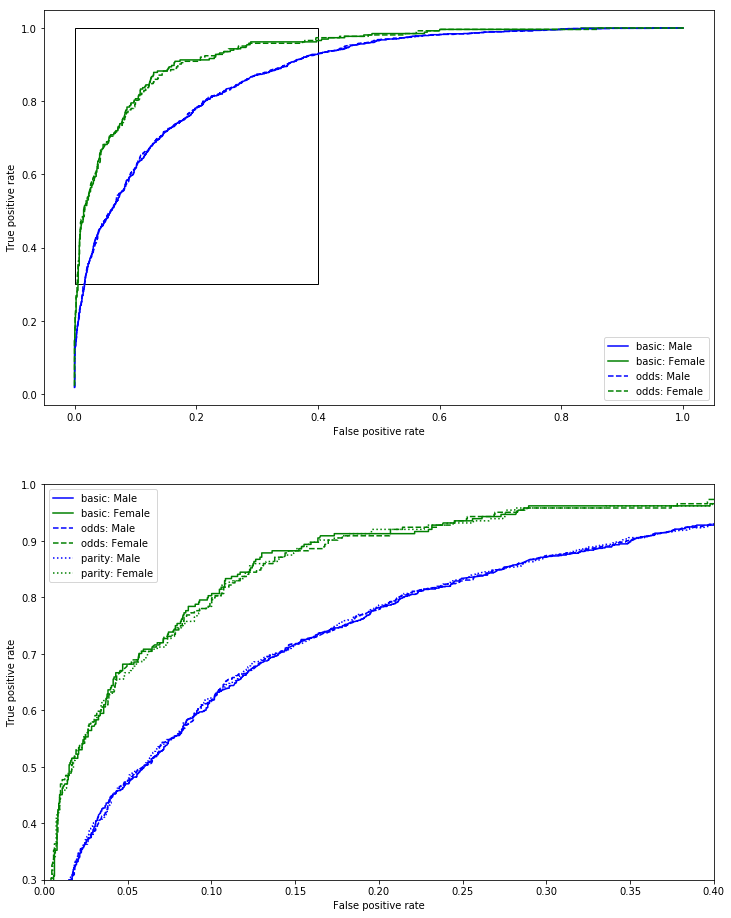

In [124]:
xrange = [0, 0.4]
yrange = [0.3, 1]
fig, axes = plt.subplots(2, 1, figsize=(12,16))
# Plot 1
plot_roc(basic_roc, axes[0], 'basic')
plot_roc(odds_roc, axes[0], 'odds')
# plot_roc(parity_roc, axes[0], 'parity')
rect = patches.Rectangle((xrange[0], yrange[0]), xrange[1] - xrange[0], yrange[1] - yrange[0],
                         linewidth=1, edgecolor='black', facecolor='none')
axes[0].add_patch(rect)
# Plot 2 (zoomed)
plot_roc(basic_roc, axes[1], 'basic', xrange=xrange, yrange=yrange)
plot_roc(odds_roc, axes[1], 'odds', xrange=xrange, yrange=yrange)
plot_roc(parity_roc, axes[1], 'parity', xrange=xrange, yrange=yrange)

[1.0000000e+00 9.9973899e-01 9.9970835e-01 ... 6.2834574e-06 6.0904099e-06
 9.9084752e-07]
[1.00000000e+00 9.05437052e-01 8.99316072e-01 8.68095815e-01
 8.66185308e-01 8.26901138e-01 8.23280156e-01 7.94085801e-01
 7.93087840e-01 7.89024413e-01 7.86633611e-01 7.56176472e-01
 7.43563890e-01 7.25870848e-01 7.21628904e-01 7.02907801e-01
 7.01660991e-01 6.90407217e-01 6.88724816e-01 6.86258137e-01
 6.86226964e-01 6.84196532e-01 6.82524800e-01 6.81975126e-01
 6.79521203e-01 6.75757289e-01 6.67722881e-01 6.56503081e-01
 6.55808389e-01 6.22287810e-01 6.22276008e-01 6.20666564e-01
 6.18858933e-01 6.18203223e-01 6.17672503e-01 6.15447402e-01
 6.13009214e-01 5.94125807e-01 5.82590997e-01 5.82060277e-01
 5.80890715e-01 5.77737272e-01 5.77301562e-01 5.76197743e-01
 5.67332923e-01 5.66330671e-01 5.62585294e-01 5.60411870e-01
 5.60012162e-01 5.54236650e-01 5.49308538e-01 5.48247337e-01
 5.45040727e-01 5.40578544e-01 5.36354184e-01 5.34341753e-01
 5.33187568e-01 5.32777667e-01 5.31192124e-01 5.3061592

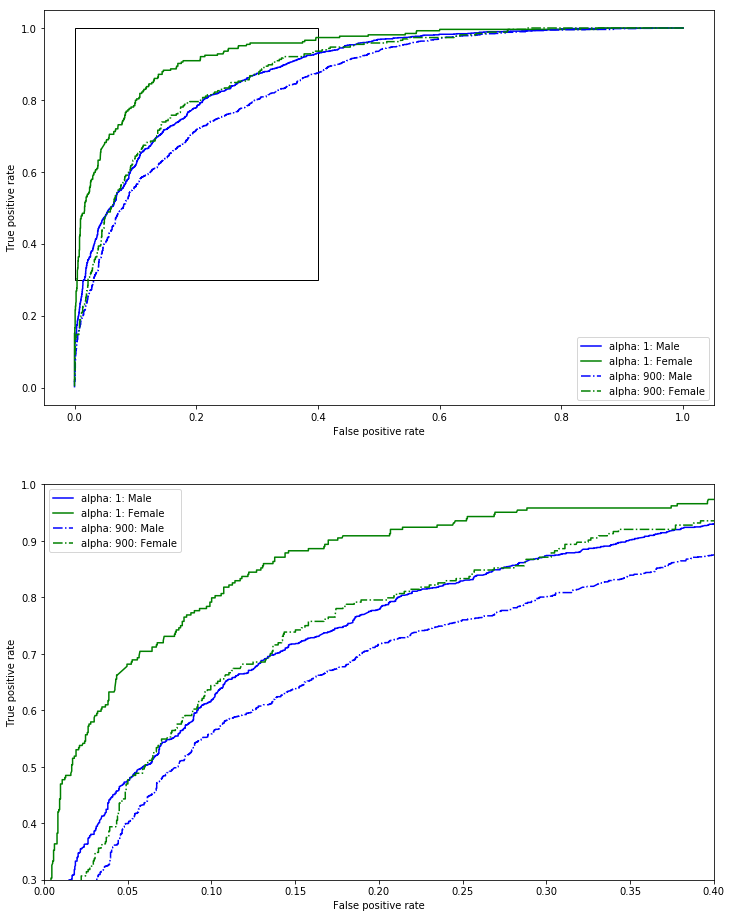

In [125]:
xrange = [0, 0.4]
yrange = [0.3, 1]
fig, axes = plt.subplots(2, 1, figsize=(12,16))
# Plot 1
for alpha in alpha_rocs:
  plot_roc(alpha_rocs[alpha], axes[0], 'alpha: ' + alpha)

rect = patches.Rectangle((xrange[0], yrange[0]), xrange[1] - xrange[0], yrange[1] - yrange[0],
                         linewidth=1, edgecolor='black', facecolor='none')
axes[0].add_patch(rect)

# Plot 2 (zoomed)
for alpha in alpha_rocs:
  plot_roc(alpha_rocs[alpha], axes[1], 'alpha: ' + alpha, xrange=xrange, yrange=yrange)

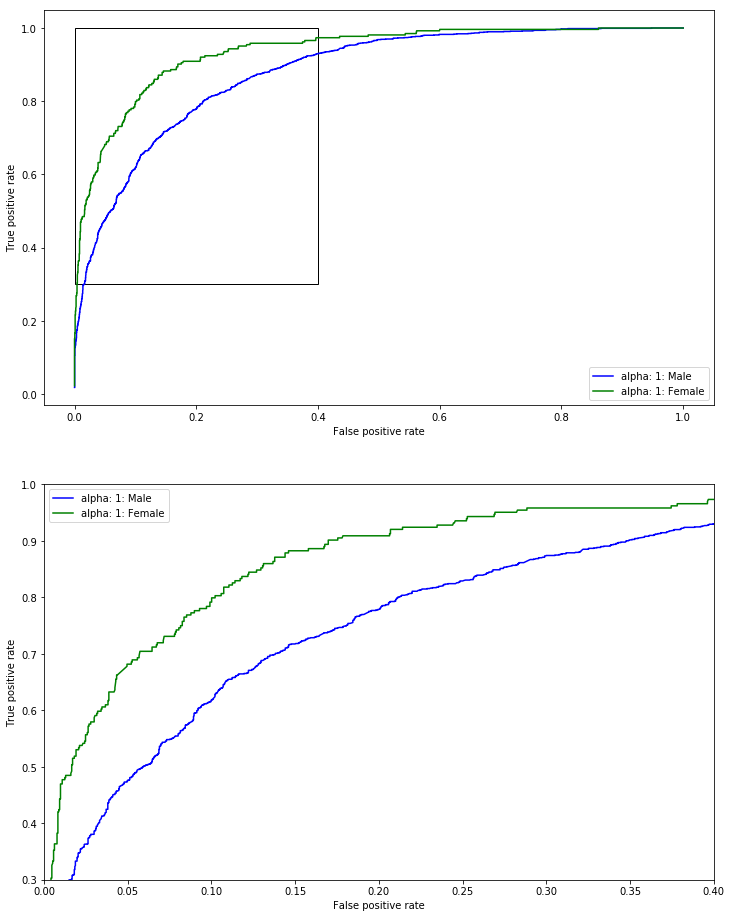

In [101]:
xrange = [0, 0.4]
yrange = [0.3, 1]
fig, axes = plt.subplots(2, 1, figsize=(12,16))
# Plot 1
alpha = '1'
plot_roc(alpha_rocs[alpha], axes[0], 'alpha: ' + alpha)

rect = patches.Rectangle((xrange[0], yrange[0]), xrange[1] - xrange[0], yrange[1] - yrange[0],
                         linewidth=1, edgecolor='black', facecolor='none')
axes[0].add_patch(rect)

# Plot 2 (zoomed)
alpha = '1'
plot_roc(alpha_rocs[alpha], axes[1], 'alpha: ' + alpha, xrange=xrange, yrange=yrange)

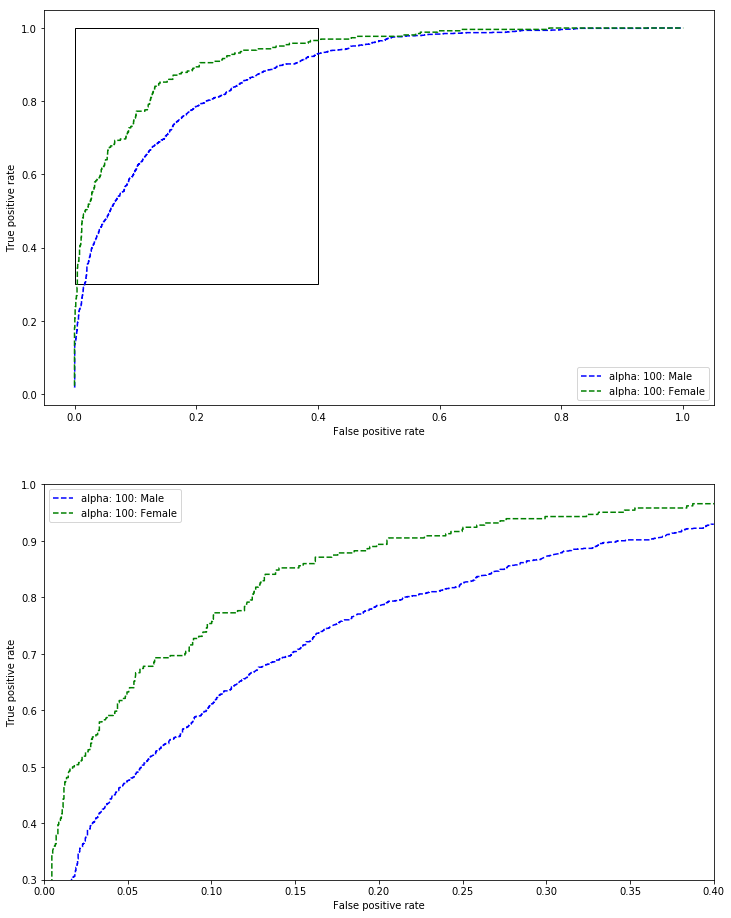

In [102]:
xrange = [0, 0.4]
yrange = [0.3, 1]
fig, axes = plt.subplots(2, 1, figsize=(12,16))
# Plot 1
alpha = '100'
plot_roc(alpha_rocs[alpha], axes[0], 'alpha: ' + alpha)

rect = patches.Rectangle((xrange[0], yrange[0]), xrange[1] - xrange[0], yrange[1] - yrange[0],
                         linewidth=1, edgecolor='black', facecolor='none')
axes[0].add_patch(rect)

# Plot 2 (zoomed)
alpha = '100'
plot_roc(alpha_rocs[alpha], axes[1], 'alpha: ' + alpha, xrange=xrange, yrange=yrange)

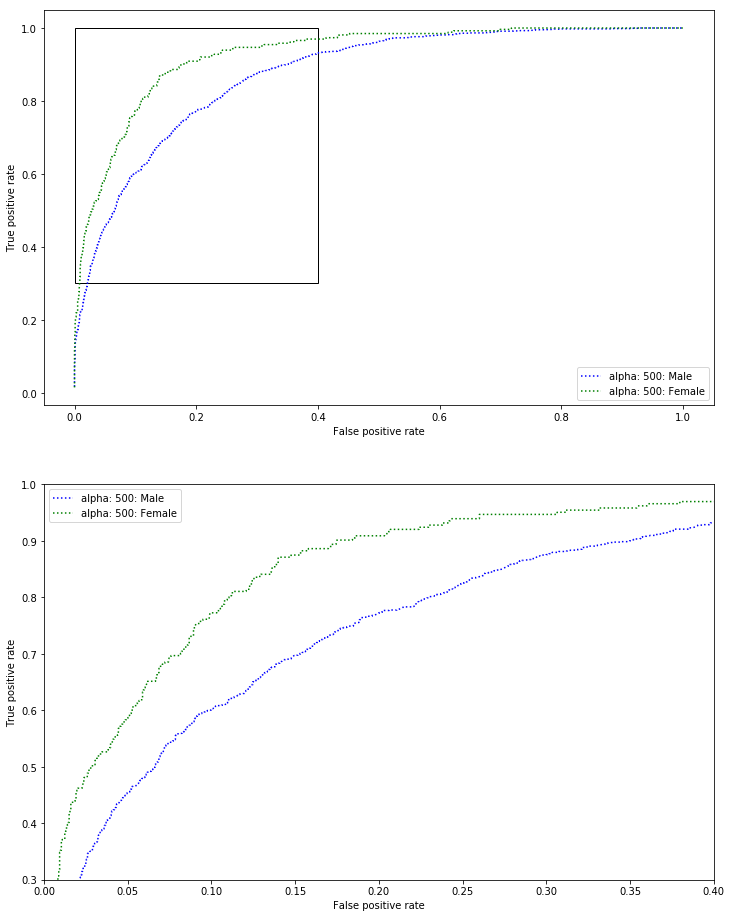

In [103]:
xrange = [0, 0.4]
yrange = [0.3, 1]
fig, axes = plt.subplots(2, 1, figsize=(12,16))
# Plot 1
alpha = '500'
plot_roc(alpha_rocs[alpha], axes[0], 'alpha: ' + alpha)

rect = patches.Rectangle((xrange[0], yrange[0]), xrange[1] - xrange[0], yrange[1] - yrange[0],
                         linewidth=1, edgecolor='black', facecolor='none')
axes[0].add_patch(rect)

# Plot 2 (zoomed)
alpha = '500'
plot_roc(alpha_rocs[alpha], axes[1], 'alpha: ' + alpha, xrange=xrange, yrange=yrange)

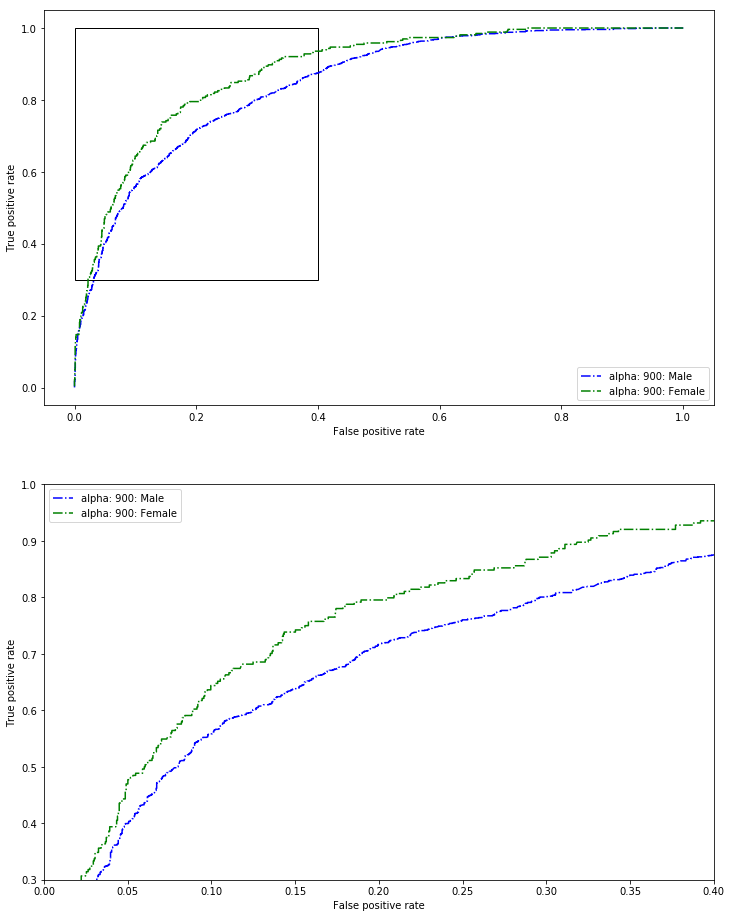

In [104]:
xrange = [0, 0.4]
yrange = [0.3, 1]
fig, axes = plt.subplots(2, 1, figsize=(12,16))
# Plot 1
alpha = '900'
plot_roc(alpha_rocs[alpha], axes[0], 'alpha: ' + alpha)

rect = patches.Rectangle((xrange[0], yrange[0]), xrange[1] - xrange[0], yrange[1] - yrange[0],
                         linewidth=1, edgecolor='black', facecolor='none')
axes[0].add_patch(rect)

# Plot 2 (zoomed)
alpha = '900'
plot_roc(alpha_rocs[alpha], axes[1], 'alpha: ' + alpha, xrange=xrange, yrange=yrange)

In [46]:
#To do: Make plot of threshold vs acc and tp / fp rates for equality of opportunity